Las celdas marcadas con un asterisco (*) deben ser ejecutadas para que las demás celdas puedan funcionar

In [1]:
import numpy as np #Para matríz de feromonas
import random #Para posicionar a las hormigas
import copy
import sys
sys.path.append('tsp')
import os
from os import path, listdir
from tsp import benchmarks,metrics,tspplot
from tsp.tspobject import TSPObject


benchmark_path = r'benchmarks'

In [2]:
class Ant(object):
    def __init__(self):
        self.visited = set() # Ciudades que ya ha visitado la hormiga
        self.tour = [] # Tour de la hormiga
        self.edges_traveled = set() #Aristas recorridas
        self.current = None # Ciudad actual
        self.L_k = 0 # Costo total del tour (Suma de todos los pesos de las aristas recorridas)

In [3]:
def two_opt_tsp(problem, tour):
    for i in range(len(problem.V)-3):
        for j in range(i+2, len(problem.V)-1):
            d1 = problem.distance(tour[i], tour[i+1]) + problem.distance(tour[j], tour[j+1])
            d2 = problem.distance(tour[i], tour[j]) + problem.distance(tour[i+1], tour[j+1])
            if(d1 > d2):
                aux = tour[j]
                tour[j] = tour[i+1]
                tour[i+1] = aux
        

### Algoritmo ACO

In [4]:
def ACO_TSP(problem, iterations, alpha, beta, l_ants, ro, c):
    ################
    # (Variable ==> Description)
    #
    # problem ==> Complete graph representing an TSP problem
    # iterations ==> Number of iterations 
    # alpha ==> influence of tao (Intenisty of pheromone)
    # beta ==> influence of ro (Visibility of city j from i)
    # l_ants ==> number of ants
    # ro ==> parameter to regulate the reduction of tao (reduccion de feromonas)
    # c ==> initial trail density for every edge (densidad de feromonas en cada camino)
    # deltaTao ==> Incremento de feromonas en un camino (arista)
    # Q ==> Feromonas expedidas por cada hormiga
    ################
    
    
    ################
    # Inicializamos variables
    ################
    shortest_tour = None
    n = len(problem.V) #V son las ciudades
    # Creamos la matríz de rastros de feromonas
    taoMatrix = np.ndarray(shape=(n,n), dtype=float, buffer=np.full(n**2, float(c))) #Matriz de n*n y rellenarla de c
    ants = [Ant() for _ in range(l_ants)]
    
    for t in range(iterations):
        #for k in range(l_ants):
        for ant in ants:
            # Place ant k on a city randomly.
            ant.current = random.choice(problem.V)
            # Place the city in visited_k.
            ant.visited.add(ant.current)
            ant.tour.append(ant.current)
        # For k = 1 to l_ants do
        for ant in ants:
            # Repeat until ant k has completed a tour
            for _ in range(n):
                # Choose the next city to be visited according to the probability function
                i_neighbors = set(neighbor for neighbor,distance in problem.neighbors(ant.current))
                allowed_neighbors = list(i_neighbors.difference(ant.visited))
                # Se necesitan calcular las probabilidades
                probabilities = []
                tao_w = [] # Conjunto de taos multiplicados por los pesos.
                
                for e in allowed_neighbors:
                    f = (taoMatrix[problem.V_idx[ant.current]][problem.V_idx[e]]**alpha)*\
                    ((1/problem.distance(ant.current, e))**beta)
                    tao_w.append(f)
                    
                tao_sum = sum(tao_w)
                
                for e in tao_w:
                    # Utilizar la formula de probabilidad
                    p = e/tao_sum
                    probabilities.append(p)
                
                if allowed_neighbors != []:
                    j = np.random.choice(allowed_neighbors,p=probabilities)
                    ant.tour.append(j)
                else:
                    j = ant.tour[0]
                # Añadimos la arista a recorrer al conjunto
                ant.edges_traveled.add((ant.current, j))
                ant.edges_traveled.add((j, ant.current))
                # Move the ant k to the selected city
                ant.current = j
                # Insert the selected city in visited_k
                ant.visited.add(j)
                
        for ant in ants:
            #Compute the tour length L_k traveled by ant k
            ant.L_k = problem.evaluate_tour(ant.tour)
            #Update the shortest tour found
            if shortest_tour == None:
                shortest_tour = ant.tour.copy()
            elif ant.L_k < problem.evaluate_tour(shortest_tour):
                shortest_tour = ant.tour.copy()
                    
        #Update the trail levels acoording to Eqs (2-4)
        for i in range(taoMatrix.shape[0]):
            for j in range(taoMatrix.shape[1]):
                #definir delta tao
                deltaTao = 0
                Q = 100
                for ant in ants:
                    if((str(i+1),str(j+1)) in ant.edges_traveled):
                        deltaTao += Q/ant.L_k
                taoMatrix[i][j] = ro * taoMatrix[i][j] + deltaTao
                
        for ant in ants:
            #Empty all visited_k
            ant.visited.clear()
            ant.tour =[]
            ant.edges_traveled.clear()
            ant.current = None
            ant.L_k = 0
            
    return shortest_tour


# Recorrido Óptimo

In [5]:
test_file = path.join(benchmark_path,'mexico32.tsp')
O = TSPObject(test_file,metrics.euc_dist)

In [6]:
optimal_tour = []
fname = 'mexico32.opt.tour'
with open(path.join(benchmark_path,fname)) as f:
    while f.readline().rstrip('\n') != 'TOUR_SECTION':
        pass

    while True:
        city = f.readline().rstrip('\n')
        if city == '-1':
            break
        optimal_tour.append(city)


---------tour optimo---------


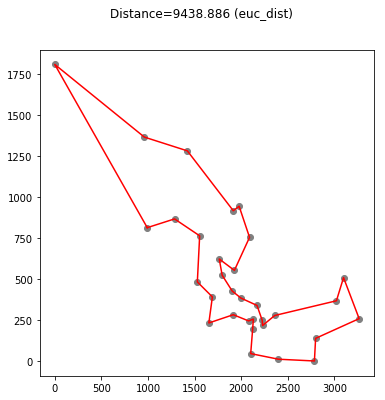

In [9]:
print("---------tour optimo---------")
tspplot.plot_tsp(O,optimal_tour, figsize=(6,6))

In [11]:
viritour = ['1', '7', '6', '8', '15', '16', '25', '21', '22', '28', '31', '30', '32', '20', '13', '19', '29', '27', '26', '24', '23', '18', '17', '14', '12', '10', '11', '9', '5', '4', '3', '2']

--------- viri tour ---------


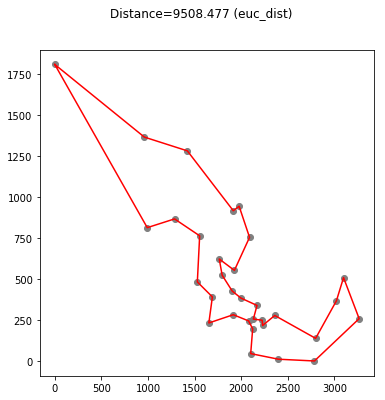

In [12]:
print("--------- viri tour ---------")
tspplot.plot_tsp(O,viritour, figsize=(6,6))

# Aplicando el algoritmo ACO al objeto TSPObject

## Análisis gráfico

In [7]:
tour = ACO_TSP(problem=O, iterations=10, alpha=5, beta=3, l_ants=100, ro=0.25, c=100)

---------tour ACO---------
['2', '3', '6', '5', '4', '9', '11', '12', '10', '14', '17', '21', '31', '24', '26', '28', '22', '23', '18', '27', '19', '13', '20', '32', '29', '30', '25', '16', '15', '8', '7', '1']


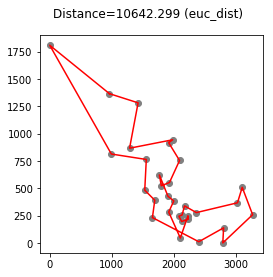

---------2 OPT------------
['2', '3', '8', '4', '5', '9', '10', '12', '11', '14', '17', '18', '27', '19', '13', '20', '29', '32', '30', '26', '24', '23', '22', '28', '31', '21', '25', '16', '15', '6', '7', '1']


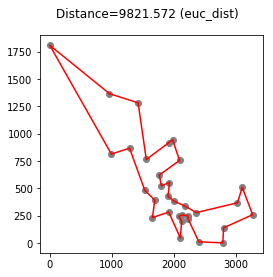

In [8]:
print("---------tour ACO---------")
print(tour)
tspplot.plot_tsp(O,tour, figsize=(4,4))
print("---------2 OPT------------")
tour_2opt = copy.copy(tour)
old_tour = None
    
while old_tour != tour_2opt:
    old_tour = copy.copy(tour_2opt)
    two_opt_tsp(O, tour_2opt)
    
print(tour_2opt)
tspplot.plot_tsp(O,tour_2opt, figsize=(4,4))


## Análisis estadístico

In [10]:
tours_sample = []
for _ in range (5):
    tour = ACO_TSP(problem=O, iterations=10, alpha=5, beta=3, l_ants=100, ro=0.25, c=100)
    tours_sample.append(O.evaluate_tour(tour))
avr = sum(tours_sample)/len(tours_sample)
opt = O.evaluate_tour(optimal_tour)
print("Optimal: {}".format(opt))
print("Average: {}".format(avr))
print("Best: {}".format(min(tours_sample)))
print("Worst: {}".format(max(tours_sample)))
print("Relative Error: {:.3}%".format(((avr-opt)/(opt))*100))
    

Optimal: 9438.885802940513
Average: 10652.148364563684
Best: 10466.415853473905
Worst: 10815.054126482508
Relative Error: 12.9%


# Generando óptimo

In [12]:
best_tour_so_far = ACO_TSP(problem=O, iterations=10, alpha=5, beta=3, l_ants=100, ro=0.25, c=100)

for i in range(40):
    tour = ACO_TSP(problem=O, iterations=10, alpha=5, beta=3, l_ants=100, ro=0.25, c=100)
    
    tour_2opt = copy.copy(tour)
    old_tour = None
    
    while old_tour != tour_2opt:
        old_tour = copy.copy(tour_2opt)
        two_opt_tsp(O, tour_2opt)
        
    if O.evaluate_tour(tour_2opt) < O.evaluate_tour(best_tour_so_far):
        best_tour_so_far = tour_2opt


---------Best tour so far---------
['7', '6', '8', '15', '16', '25', '21', '22', '23', '28', '31', '30', '32', '20', '13', '19', '29', '27', '26', '24', '18', '17', '14', '11', '12', '10', '9', '5', '4', '3', '2', '1']


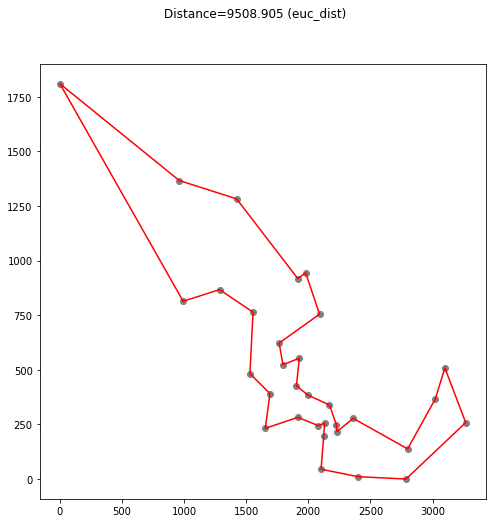

In [13]:
print("---------Best tour so far---------")
print(best_tour_so_far)
tspplot.plot_tsp(O,best_tour_so_far, figsize=(8,8))